# (09) Figs: NeurIPS

**Motivation**: Make figures for NeurIPS. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Fig save dir

In [2]:
fig_dir = pjoin(fig_base_dir, 'nips_may22')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 600,
}

[]

## Device

In [3]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Load model, plot dec weights

In [4]:
models2load = {
    'poisson': dict(
        model_name='poisson_uniform_c(-4)_DOVES_z-512_fp_<lin|lin>',
        fit_name='mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_05_08,19:25)'),
    'gaussian': dict(
        model_name='gaussian_DOVES_z-512_<lin|lin>',
        fit_name='mc_b1000-ep3000-lr(0.005)_beta(1:0x0.5)_gr(500)_(2024_05_08,19:28)'),
}

In [5]:
trainers = {}
for name, load_info in models2load.items():
    try:
        trainers[name], _ = load_model(
            model_name=load_info['model_name'],
            fit_name=load_info['fit_name'],
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 262.7 K

# params: 394.2 K

### Poisson

In [6]:
tr = trainers['poisson']
data, loss, etc = tr.validate()

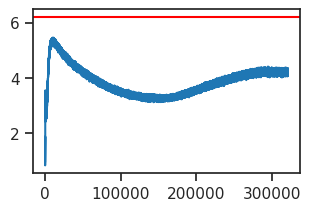

In [7]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

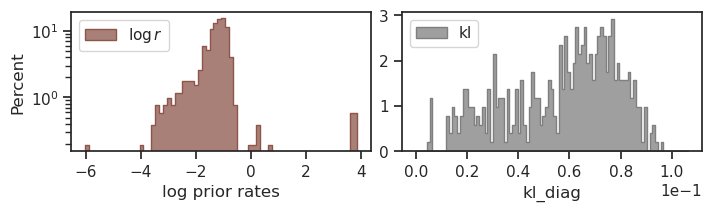

In [8]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(tonp(tr.model.log_rate.squeeze()), label=r'$\log r$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

add_legend(axes, loc='upper left')
axes[0].set(xlabel='log prior rates', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='linear')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

In [9]:
dead_thres = 0.009
dead = np.logical_or(
    loss['kl_diag'] < dead_thres,
    tonp(tr.model.log_rate.squeeze()) > 1.0,
)
dead.sum()

7

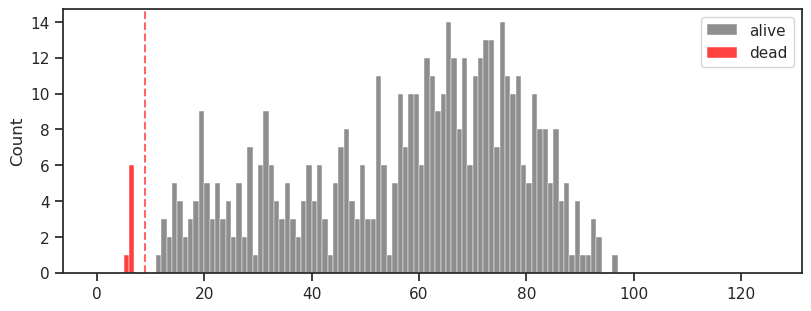

In [10]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 125, 126)
sns.histplot(loss['kl_diag'][~dead] * 1000, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 1000, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

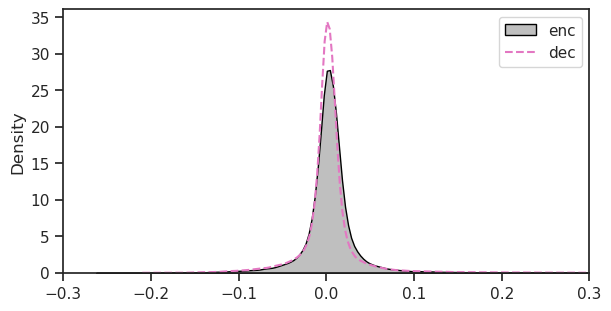

In [11]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.3, 0.3))
add_legend(ax)
plt.show()

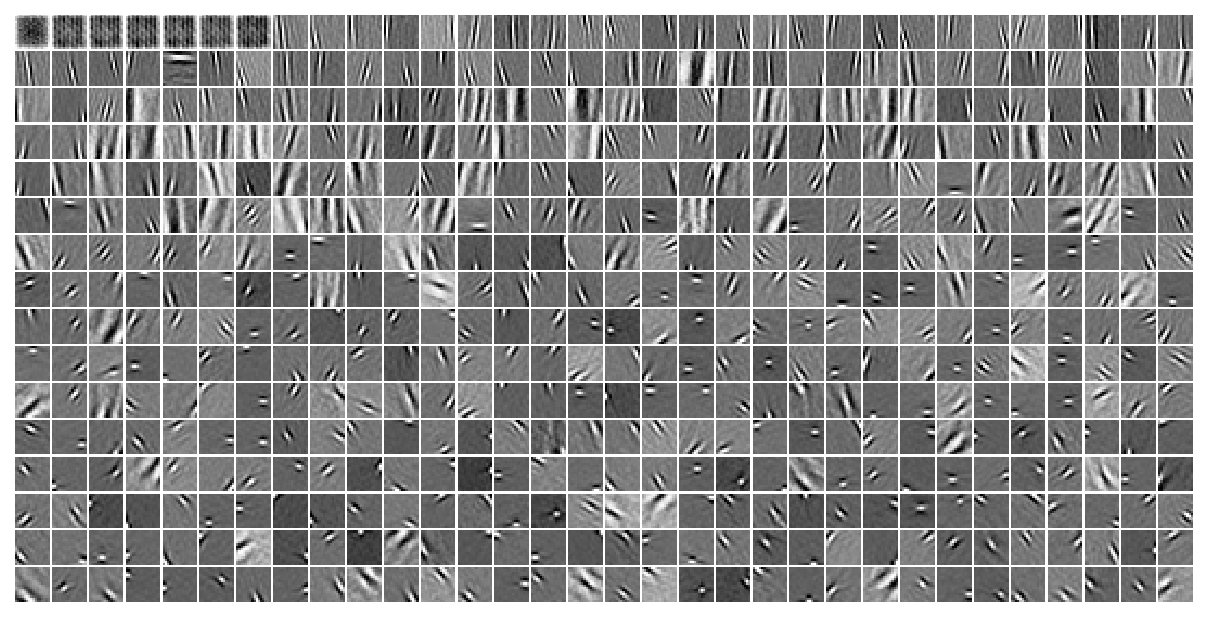

In [12]:
tr.model.show(dpi=150, order=np.argsort(loss['kl_diag']));

### Gaussian

In [13]:
tr = trainers['gaussian']
data, loss, etc = tr.validate()

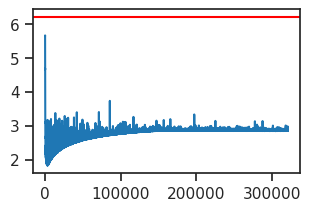

In [14]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

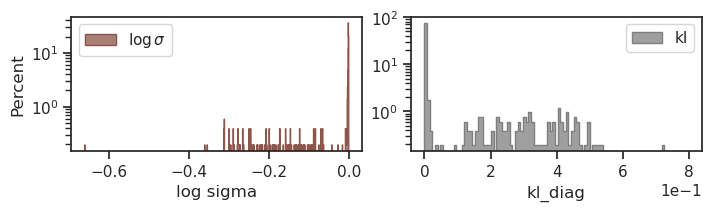

In [15]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(np.log(etc['scale'].mean(0)), label=r'$\log \sigma$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper right')
axes[0].set(xlabel='log sigma', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='log')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

In [16]:
dead_thres = 8e-2
dead = loss['kl_diag'] < dead_thres
dead.sum()

400

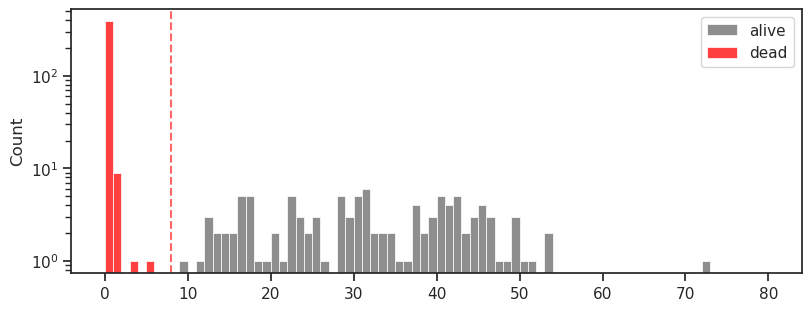

In [17]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 80, 81)
sns.histplot(loss['kl_diag'][~dead] * 100, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 100, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 100, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.set(yscale='log')
ax.legend()
plt.show()

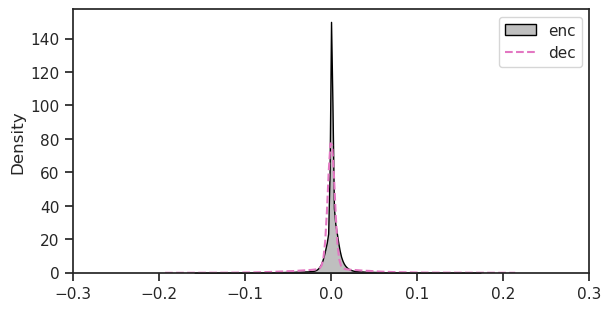

In [18]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.3, 0.3))
add_legend(ax)
plt.show()

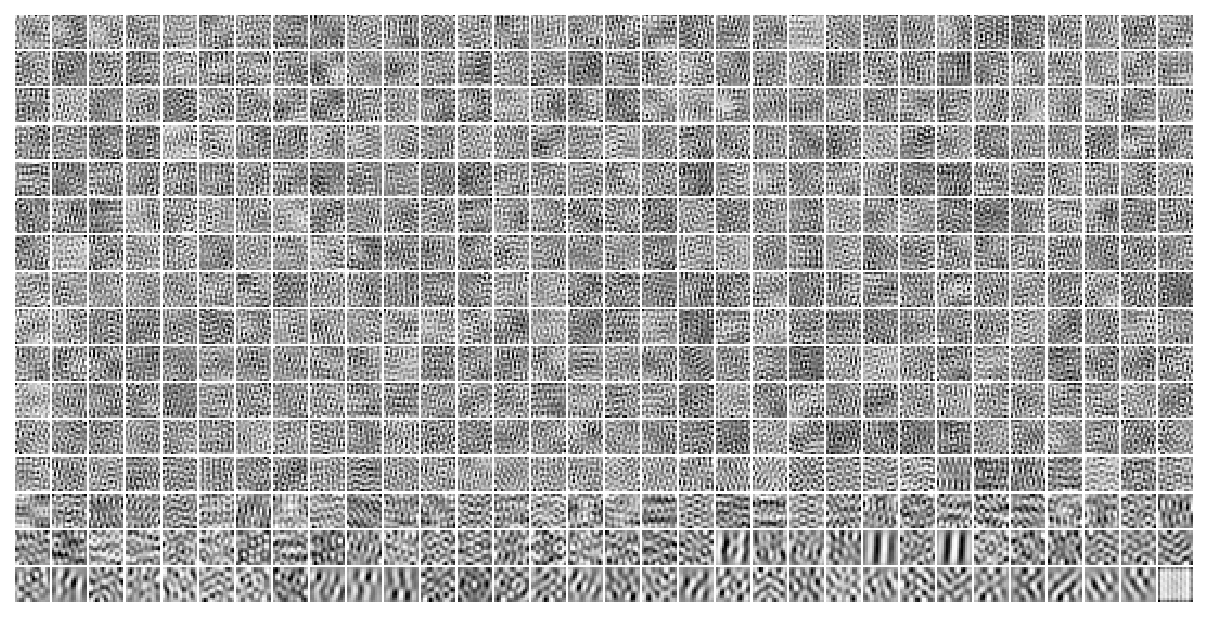

In [19]:
tr.model.show(dpi=150, order=np.argsort(loss['kl_diag']));